
# MSIT 3103 · Assignment 3 Hotstart Notebook  
**Prompt Engineering Lab with Local Models (Ollama + LLaMA 3.2 1B)**

> Use this notebook to run structured prompt‑engineering experiments on a **local** small model (e.g., `llama3.2:1b` via Ollama).  
> You will implement Steps 1–4 (Basic → Structured → Few‑shot → CoT), collect outputs, and analyze results.



## 0) Local Environment Check

This notebook assumes you have **[Ollama](https://ollama.com/)** installed locally and the `llama3.2:1b` model available.

- Install Ollama: follow your OS‑specific steps from the website.  
- Pull the model (in a terminal):  
```bash
ollama pull llama3.2:1b
```
- Verify command works (from terminal): `ollama run llama3.2:1b "hello"`

> If you're executing this notebook on a machine without Ollama, use these cells as **documentation** and run the actual commands on your local machine. You can paste results back here for analysis.


In [ ]:

import json, os, subprocess, time, uuid, textwrap
from dataclasses import dataclass, asdict
from typing import List, Dict

RESULTS_DIR = "a3_outputs"
os.makedirs(RESULTS_DIR, exist_ok=True)

def ollama_run(model: str, prompt: str, options: Dict=None, timeout: int = 120) -> str:
    """Run a prompt through a local Ollama model via subprocess and return the text.

    Requires Ollama to be installed and available on PATH.

    """
    container_name = "ollama"
    # cmd = ["ollama", "run", model]
    cmd = ["docker", "exec", "-i", container_name, "ollama", "run", model]
    if options:
        # Ollama CLI supports options via the JSON API; here we keep CLI simple.
        # For advanced options, consider using `ollama generate -m model -p prompt --options '{...}'` pattern.
        pass
    proc = subprocess.run(cmd, input=prompt.encode("utf-8"), stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=timeout)
    if proc.returncode != 0:
        raise RuntimeError(f"Ollama error: {proc.stderr.decode('utf-8', errors='ignore')}")
    return proc.stdout.decode("utf-8", errors="ignore")

@dataclass
class Trial:
    step: str                 # basic / structured / fewshot / cot
    task_id: str              # arbitrary id of the task/question
    prompt: str
    response: str
    meta: Dict

def save_trials(trials: List[Trial], path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump([asdict(t) for t in trials], f, ensure_ascii=False, indent=2)
    print(f"Saved {len(trials)} trials to {path}")



## 1) Context Document & Tasks

Create/Load a short **context document** (few paragraphs) and a small set of **tasks** to query the model with.  
You may replace the placeholder context and tasks below with your own domain (e.g., finance, health, policy, product requirements).

> Keep **5–10 tasks** so runs complete quickly.


In [ ]:

CONTEXT = """
Acme Coffee is launching a mobile ordering app. Users can customize drinks, save favorites, and schedule pickup.
New features include: seasonal drinks, reward points, referral codes, and a barista recommendation assistant.
The team tracks weekly KPIs: daily active users (DAU), average order value (AOV), and retention D7.
""".strip()

TASKS = [
    {"id": "t1", "question": "Summarize the key features of the Acme Coffee app."},
    {"id": "t2", "question": "List three KPIs and explain why they matter."},
    {"id": "t3", "question": "Propose two experiments to increase AOV."},
    {"id": "t4", "question": "Write a short FAQ answer: 'How do I redeem reward points?'"}
]

print(CONTEXT)
print("\nTasks:")
for t in TASKS:
    print("-", t["id"] + ":", t["question"])


Acme Coffee is launching a mobile ordering app. Users can customize drinks, save favorites, and schedule pickup.
New features include: seasonal drinks, reward points, referral codes, and a barista recommendation assistant.
The team tracks weekly KPIs: daily active users (DAU), average order value (AOV), and retention D7.

Tasks:
- t1: Summarize the key features of the Acme Coffee app.
- t2: List three KPIs and explain why they matter.
- t3: Propose two experiments to increase AOV.
- t4: Write a short FAQ answer: 'How do I redeem reward points?'



## 2) Step 1 — Basic Prompting

- Ask direct, simple questions grounded in the context document.
- Log correctness, completeness, and clarity for later comparison.


In [ ]:

MODEL = "llama3.2:1b"

basic_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant.

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    basic_trials.append(Trial(step="basic", task_id=task["id"], prompt=prompt, response=resp, meta={}))

save_trials(basic_trials, os.path.join(RESULTS_DIR, "step1_basic.json"))


Saved 4 trials to a3_outputs\step1_basic.json



## 3) Step 2 — Structured Output Prompts

- Instruct the model to output **strict JSON** or bullet lists/tables.
- Compare accuracy & reliability with Step 1.


In [ ]:

structured_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant. Return the answer in **strict JSON** with keys:
- "answer": string
- "supporting_facts": list of short strings derived from the context
- "confidence": number in [0,1]

Context:
{CONTEXT}

Question:
{task['question']}

If something is unknowable from the context, set "confidence": 0 and use an empty "supporting_facts".
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    structured_trials.append(Trial(step="structured", task_id=task["id"], prompt=prompt, response=resp, meta={"format":"json"}))

save_trials(structured_trials, os.path.join(RESULTS_DIR, "step2_structured.json"))


Saved 4 trials to a3_outputs\step2_structured.json



## 4) Step 3 — Few‑shot Prompting

- Provide **1–3 short examples** to steer the style & content.
- Compare results with Steps 1–2.


In [ ]:

FEW_SHOT_EXAMPLES = [
    {
        "q": "List two seasonal drinks in the app and describe them briefly.",
        "a": "- Pumpkin Spice Latte: spiced espresso with milk\n- Peppermint Mocha: minty chocolate espresso"
    },
    {
        "q": "Explain what DAU means.",
        "a": "Daily Active Users; the number of unique users opening the app on a given day."
    }
]

def render_fewshot_block(examples):
    parts = ["You are a helpful assistant. Here are some QA examples:"]
    for ex in examples:
        parts.append(f"Q: {ex['q']}\nA: {ex['a']}")
    return "\n\n".join(parts)

fewshot_prefix = render_fewshot_block(FEW_SHOT_EXAMPLES)

fewshot_trials = []
for task in TASKS:
    prompt = f"""
{fewshot_prefix}

Now answer the new question using the context below.

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    fewshot_trials.append(Trial(step="fewshot", task_id=task["id"], prompt=prompt, response=resp, meta={"k": len(FEW_SHOT_EXAMPLES)}))

save_trials(fewshot_trials, os.path.join(RESULTS_DIR, "step3_fewshot.json"))


Saved 4 trials to a3_outputs\step3_fewshot.json



## 5) Step 4 — Chain‑of‑Thought (CoT) Prompting

- Encourage explicit reasoning (e.g., _"Let's think step by step."_).  
- Compare reasoning quality, correctness, and verbosity with prior steps.

> **Note:** When writing your report, avoid pasting raw CoT traces if disallowed by an evaluation policy. Summarize the reasoning instead.


In [ ]:

cot_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant. Let's think step by step and show reasoning before the final answer.
Use the context to avoid hallucinations. Provide a short final answer at the end under 'Final Answer: ...'.

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    cot_trials.append(Trial(step="cot", task_id=task["id"], prompt=prompt, response=resp, meta={"cot": True}))

save_trials(cot_trials, os.path.join(RESULTS_DIR, "step4_cot.json"))


Saved 4 trials to a3_outputs\step4_cot.json



## 6) Scoring Scaffold (Manual or Programmatic)

Rate each response on:
- **Correctness** (0–5), **Completeness** (0–5), **Clarity** (0–5).  
Optionally mark factual errors.

Fill the table below manually (or write a simple heuristic scorer).


In [ ]:

import json, glob, pandas as pd

def load_trials(pattern):
    rows = []
    for path in sorted(glob.glob(pattern)):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        for item in data:
            rows.append({
                "file": os.path.basename(path),
                "step": item["step"],
                "task_id": item["task_id"],
                "prompt": item["prompt"],
                "response": item["response"],
            })
    return pd.DataFrame(rows)

df = load_trials(os.path.join(RESULTS_DIR, "step*.json"))
df.head()


,file,step,task_id,prompt,response
0,step1_basic.json,basic,t1,You are a helpful assistant.\n\nContext:\nAcme...,Here are the key features of the Acme Coffee m...
1,step1_basic.json,basic,t2,You are a helpful assistant.\n\nContext:\nAcme...,Here are three key performance indicators (KPI...
2,step1_basic.json,basic,t3,You are a helpful assistant.\n\nContext:\nAcme...,To increase Average Order Value (AOV) through ...
3,step1_basic.json,basic,t4,You are a helpful assistant.\n\nContext:\nAcme...,Here's a short FAQ answer:\n\nQ: How do I rede...
4,step2_structured.json,structured,t1,You are a helpful assistant. Return the answer...,"```json\n{\n ""answer"": ""The Acme Coffee app o..."


In [ ]:

# Add scoring columns and export a CSV for manual rating
df_scores = df.copy()
for col in ["correctness_0_5", "completeness_0_5", "clarity_0_5", "notes"]:
    if col not in df_scores.columns:
        df_scores[col] = ""

out_csv = os.path.join(RESULTS_DIR, "ratings_template.csv")
df_scores.to_csv(out_csv, index=False)
out_csv


'a3_outputs\\ratings_template.csv'


## 7) Aggregate & Compare

After you fill in `ratings_template.csv`, re‑import and compute per‑step averages.


In [ ]:

import pandas as pd, numpy as np

ratings_path = os.path.join(RESULTS_DIR, "ratings_template.csv")
ratings = pd.read_csv(ratings_path)

def to_num(x):
    try:
        return float(x)
    except:
        return np.nan

ratings["correctness_0_5"] = ratings["correctness_0_5"].apply(to_num)
ratings["completeness_0_5"] = ratings["completeness_0_5"].apply(to_num)
ratings["clarity_0_5"] = ratings["clarity_0_5"].apply(to_num)

summary = ratings.groupby("step")[["correctness_0_5","completeness_0_5","clarity_0_5"]].mean().round(2)
summary


,correctness_0_5,completeness_0_5,clarity_0_5
step,,,
basic,3.5,4.50,4.50
cot,3.0,4.25,3.75
fewshot,3.0,4.25,4.50
structured,2.5,2.25,3.75



## 8) Visualization

Plot average scores by step (Basic vs Structured vs Few‑shot vs CoT).


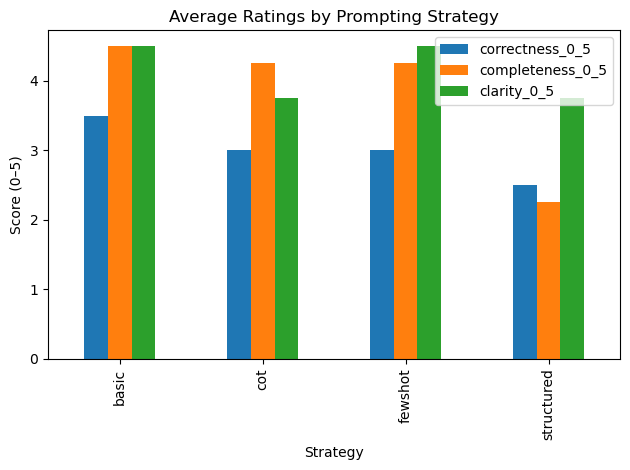

In [ ]:

import matplotlib.pyplot as plt

summary.plot(kind="bar")
plt.title("Average Ratings by Prompting Strategy")
plt.ylabel("Score (0–5)")
plt.xlabel("Strategy")
plt.tight_layout()
plt.show()
